<a href="https://colab.research.google.com/github/mjmousavi97/Graph-Neural-Networks/blob/main/08_GNN_Architects/src/GraphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GraphSAGE is a Graph Neural Network (GNN) architecture designed to handle large-scale graphs.  
In the tech industry, scalability is one of the key factors driving growth. Therefore, systems are inherently built to support millions of users.  
This capability requires a fundamental shift in how GNN models operate compared to architectures like **GCN** and **GAT**.  
For this reason, it is no surprise that **GraphSAGE** has become the architecture of choice for companies such as **Uber Eats** and **Pinterest**.  

In this chapter, we explore the two main ideas behind GraphSAGE:  
1. The **neighbor sampling** technique, which forms the core of its scalability and efficiency.  
2. Three types of **aggregation operators** used to generate node embeddings.  



**GraphSAGE** (Hamilton et al., 2017) is a scalable Graph Neural Network (GNN) designed for **inductive representation learning** on large graphs.  
It addresses two main issues of traditional GNNs like GCN and GAT:
1. **Scalability** to large graphs  
2. **Generalization** to unseen data  

The model works by:
- **Sampling a fixed number of neighbors** (neighbor sampling) instead of using all connected nodes  
- **Aggregating information** from these sampled neighbors to compute node embeddings  

This approach prevents the **computation graph from growing exponentially** and allows efficient **mini-batch training** on GPUs.  
For example, sampling 3 neighbors at the first hop and 5 at the second limits the computation graph to only 15 nodes.


___

## Node Classification on PubMed

- **Dataset:** PubMed citation network (Planetoid family), available under MIT license [GitHub](https://github.com/kimiyoung/planetoid)  
- **Graph size:** 19,717 nodes, 88,648 edges  
- **Node features:** 500-dimensional TF-IDF-weighted word vectors  
- **Task:** Classify nodes into three categories:  
  1. Diabetes Mellitus Experimental  
  2. Diabetes Mellitus Type 1  
  3. Diabetes Mellitus Type 2  

We will implement this step by step using **PyTorch Geometric (PyG)**.


In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.9 MB/s eta 0:00:00


In [4]:
from torch_geometric.datasets import Planetoid

In [5]:
dataset = Planetoid(root='.', name='PubMed')
data = dataset[0]

print(f'Dataset: {dataset}')

Dataset: PubMed()


In [6]:
print('Dataset: ')
print('--------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}{'\n'}")

print('Graph: ')
print('------')
print(f'Training Nodes = {data.train_mask.sum()}')
print(f'Validation Nodes = {data.val_mask.sum()}')
print(f'Testing Nodes = {data.test_mask.sum()}')

Dataset: 
--------
Number of graphs: 1
Number of features: 500
Number of classes: 3
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50

Graph: 
------
Training Nodes = 60
Validation Nodes = 500
Testing Nodes = 1000


# 🧑‍💻 Neighbor Sampling and Mini-Batch Training with PyG's NeighborLoader

In large graphs, it’s **impossible to load all nodes and edges into memory at once**. GraphSAGE solves this problem by **sampling only a small subgraph** around a set of target nodes at each training step—a technique known as **mini-batch training on graphs**. The `NeighborLoader` class in PyTorch Geometric performs this **neighbor sampling** automatically to create the required subgraphs.

Here is how you initialize it:

```python
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)
```

The parameters work as follows: input_nodes=data.train_mask ensures only nodes in the training mask are chosen as the starting target nodes for prediction and loss calculation. batch_size=16 means 16 target nodes are selected in each iteration. num_neighbors=[10, 10] defines the sampling depth and width: for each target node, it samples 10 first-hop neighbors, and then 10 second-hop neighbors from those, creating a two-layer neighborhood ideal for a 2-layer GraphSAGE model.

In each batch iteration, 16 target nodes are picked. Their neighbors across 1-hop and 2-hop distances are randomly sampled from the entire graph (not restricted to the training set). A subgraph is then created containing the 16 target nodes, their sampled neighbors, and all edges connecting them. Key Points: Neighbor nodes can belong to the train, validation, or test sets, and neighbors/edges may be shared between different target nodes, leading to efficient computation.

The NeighborLoader returns each batch as a torch_geometric.data.Data object. This batch object contains: batch.x (Node features of all nodes in the subgraph), batch.edge_index (Edges within the subgraph with re-indexed nodes), batch.y (Labels for all nodes), batch.batch_size (The number of target nodes, e.g., 16), and batch.n_id (The original indices of these nodes in the full graph).

In [10]:
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version: {torch.version.cuda}") # اگر None بود، از CPU استفاده می کنید.

PyTorch Version: 2.8.0+cu126
CUDA Version: 12.6


In [11]:
!pip install pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 144.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 140.6 MB/s eta 0:00:00


In [7]:
from torch_geometric.loader import NeighborLoader

In [8]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

By printing their information, let’s verify that we obtained four subgraphs (batches):

In [10]:
for i, subgraph in enumerate(train_loader):
    print(f'Batch {i+1}:')
    print(f'Number of nodes: {subgraph.num_nodes}')
    print(f'Number of edges: {subgraph.num_edges}')

Batch 1:
Number of nodes: 526
Number of edges: 622
Batch 2:
Number of nodes: 291
Number of edges: 371
Batch 3:
Number of nodes: 362
Number of edges: 437
Batch 4:
Number of nodes: 233
Number of edges: 293


Now, we will plot these subgraphs using matplotlib's subplots:

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.utils import to_networkx

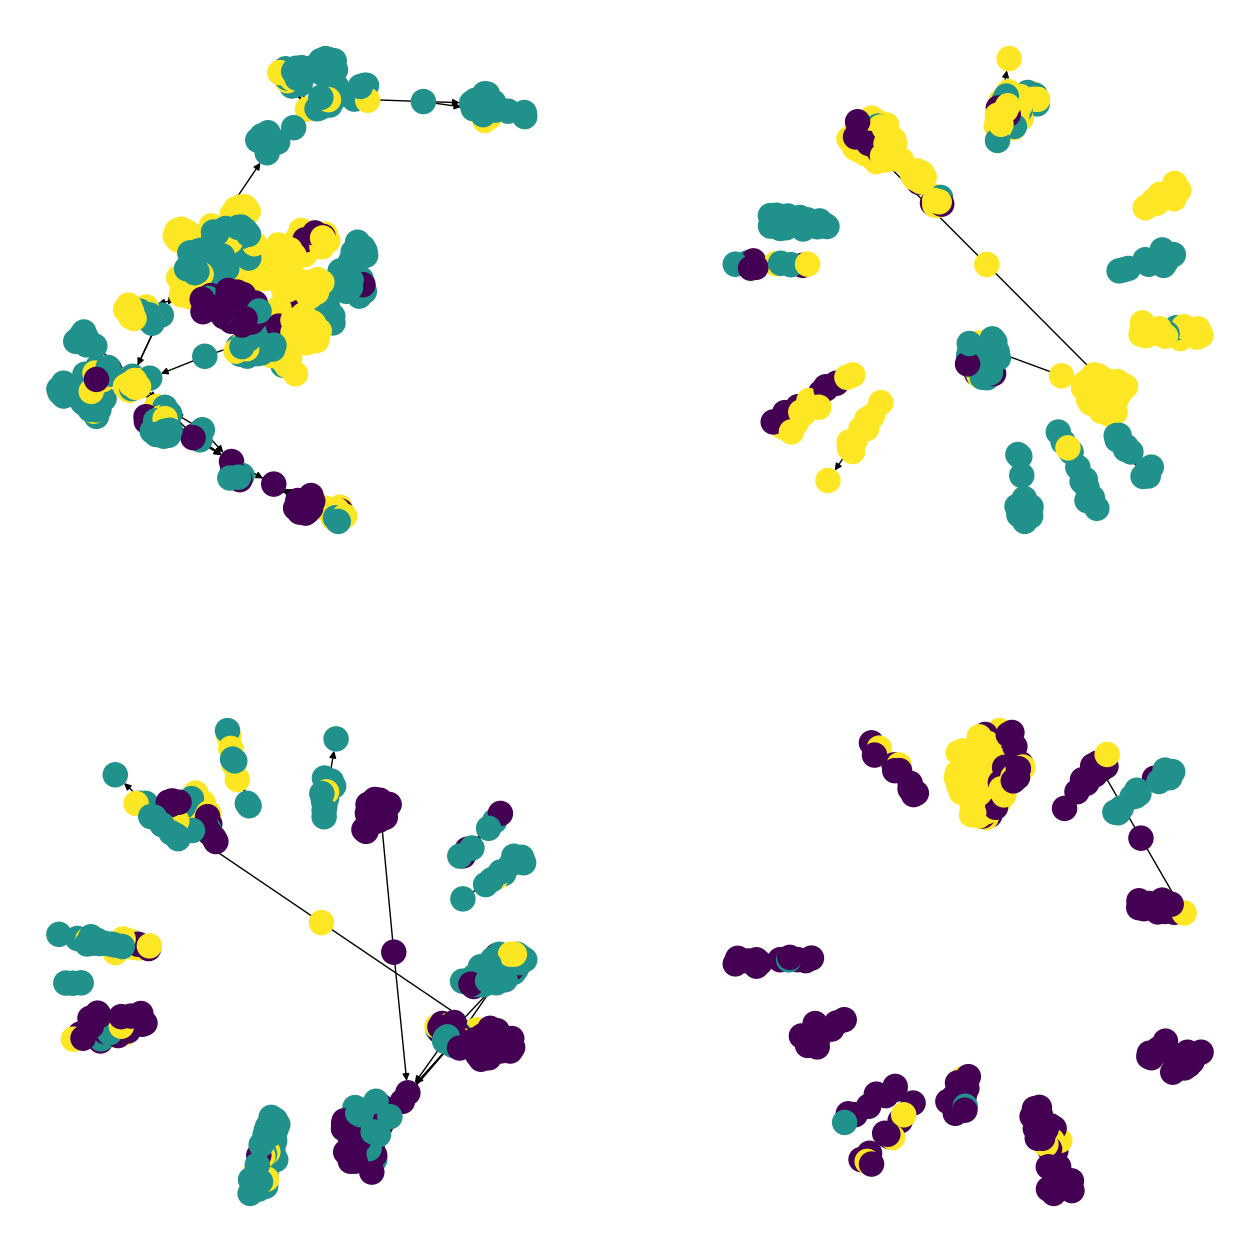

In [14]:
plt.figure(figsize=(16, 16))

pos = [221, 222, 223, 224]
for idx, subgraph in enumerate(train_loader):
    nx_graph = to_networkx(subgraph)
    plt.subplot(pos[idx])
    plt.axis('off')
    nx.draw_networkx(nx_graph, pos=nx.spring_layout(nx_graph, seed=42), with_labels=False, node_color=subgraph.y.numpy())

plt.show()